# Map trends in climate variables

* P:PET
* VPD
* rainfall
* WCF

In [1]:
%matplotlib inline

import sys
import dask
import warnings
import odc.geo.xr
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import contextily as ctx
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from xarrayMannKendall import Mann_Kendall_test

In [ ]:
# import sys
# sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
# from _utils import start_local_dask

# client = start_local_dask(mem_safety_margin='2Gb')
# client

## Analysis Parameters


In [ ]:
# dask = None#dict(latitude=250,longitude=250)

## Open data

* Penman PET from AWRA: '/g/data/os22/chad_tmp/NEE_modelling/data/5km/PET_5km_monthly_2002_2021.nc'
* Pan evaporation from ANUClim: '/g/data/os22/chad_tmp/NEE_modelling/data/1km/evap_1km_monthly_2002_2021.nc'
* MI: '/g/data/os22/chad_tmp/NEE_modelling/data/5km/MI_5km_monthly_2002_2021.nc'
* AI: '/g/data/os22/chad_tmp/NEE_modelling/data/5km/AridityIndex_5km_monthly_2002_2021.nc'

In [ ]:
#.sel(time=slice('1990','2022'))

In [3]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
vpd = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/vpd_5km_monthly_1982_2022.nc')['vpd']
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('1982','2022'))

mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.rename('P:PET')
mi = xr.where(mi>5, 5, mi) #remove extreme values

In [ ]:
# trees.mean(['latitude','longitude']).plot(figsize=(11,4))

In [ ]:
# wcf.mean(['latitude','longitude']).plot(figsize=(11,4))

## Annual trends

In [ ]:
a_rain = rain.resample(time='YE', label='left').sum()
mask = xr.where(a_rain.max('time')==0, 0, 1)
a_rain = a_rain.where(mask)

a_vpd = vpd.resample(time='YE', label='left').mean()
a_mi = mi.resample(time='YE', label='left').mean()
a_trees = trees.resample(time='YE', label='left').mean()

In [ ]:
annual_res = {}
prod =[a_rain, a_vpd, a_mi, a_trees]
names = ['rainfall', 'VPD', 'Aridity', 'Trees']
for ds, name in zip(prod,names):
    print(name)
    _trends = Mann_Kendall_test(ds,
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'})
                              
    annual_res[name] = _trends.compute()

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(9,8),sharey=True,sharex=True, layout='constrained')
cmaps = ['BrBG', 'RdBu_r', 'PuOr', 'Spectral']
labels = 'Rainfall mm yr\u207B\u00B9', 'VPD HPa yr\u207B\u00B9', 'P:PET yr\u207B\u00B9', 'Trees Fraction yr\u207B\u00B9'

for s, a, cmap, l in zip(names, ax.reshape(-1), cmaps, labels):
    if s=='VPD':
        im = annual_res[s].trend.where(annual_res[s].trend!=0).plot(ax=a, cmap=cmap,vmin=-0.1, vmax=0.1, add_colorbar=False)
    else:
        im = annual_res[s].trend.where(annual_res[s].trend!=0).plot(ax=a, cmap=cmap,robust=True, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(annual_res[s].trend.where(annual_res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)

    axins = inset_axes(a, width="55%",height="5%",loc="lower left", borderpad=2)
    cbar3 = fig.colorbar(im, cax=axins, orientation='horizontal')
    cbar3.ax.set_title(l, fontsize=10)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

fig.savefig("/g/data/os22/chad_tmp/Aus_phenology/results/figs/climate_annual_trends.png", bbox_inches='tight', dpi=300)

## Seasonal trends

In [4]:
q_rain = rain.resample(time='QE-DEC', label='left').sum()
q_vpd = vpd.resample(time='QE-DEC', label='left').mean()
q_mi = mi.resample(time='QE-DEC', label='left').mean()
# q_wcf = wcf.resample(time='QE-DEC', label='left').mean()

#mask zeros from the sum() for rainfall
mask = xr.where(q_rain.mean('time')==0, 0, 1)
q_rain = q_rain.where(mask)

#because DJF is missing in 1981 Dec, start in March 1982
q_rain = q_rain.sel(time=slice('1982-03','2022'))
q_vpd = q_vpd.sel(time=slice('1983-03','2022'))
q_mi = q_mi.sel(time=slice('1983-03','2022'))
# q_wcf = q_wcf.sel(time=slice('1983-03','2022'))

In [ ]:
rain_res = {}
for season in ("DJF", "MAM", "JJA", "SON"):
    print(season)
    xx = q_rain.sel(time=q_rain['time.season']==season)
    xx['time'] = xx.time.dt.year
    _trends = Mann_Kendall_test(xx,
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}
                              ).compute()
    rain_res[season] = _trends


In [ ]:
fig,ax = plt.subplots(1,4, figsize=(15,4),sharey=True, layout='constrained')
for s, a in zip(["DJF", "MAM", "JJA", "SON"], ax.reshape(-1)):
    im = rain_res[s].trend.where(rain_res[s].trend!=0).plot(ax=a, cmap='BrBG', vmin=-5, vmax=5, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(rain_res[s].trend.where(rain_res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    a.set_title(s)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.65, orientation='vertical', label='Rainfall trend (mm/yr)')
fig.savefig("/g/data/os22/chad_tmp/Aus_phenology/results/figs/rainfall_seasonal_trends.png", bbox_inches='tight', dpi=300)

In [5]:
vpd_res = {}
for season in ("DJF", "MAM", "JJA", "SON"):
    print(season)
    xx = q_vpd.sel(time=q_vpd['time.season']==season)
    xx['time'] = xx.time.dt.year
    _trends = Mann_Kendall_test(xx,
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}
                              ).compute()
    vpd_res[season] = _trends

DJF


/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


MAM
JJA
SON


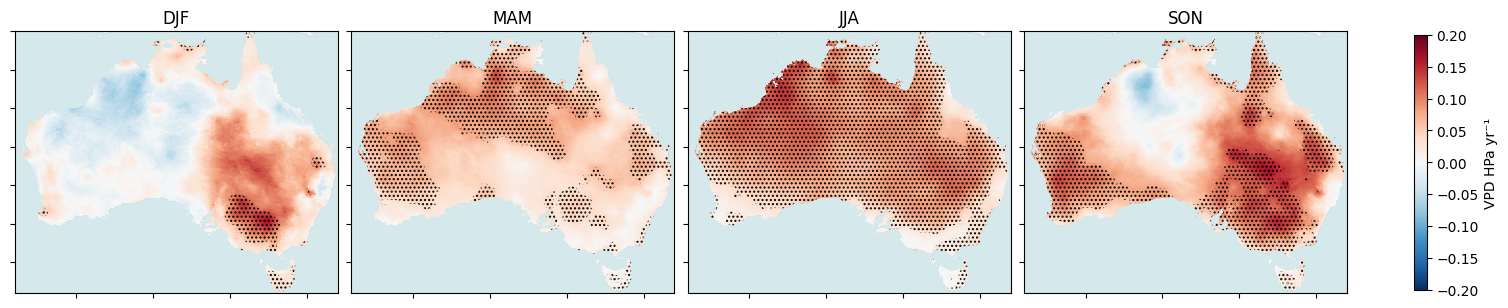

In [7]:
fig,ax = plt.subplots(1,4, figsize=(15,4),sharey=True, layout='constrained')
for s, a in zip(["DJF", "MAM", "JJA", "SON"], ax.reshape(-1)):
    im = vpd_res[s].trend.where(vpd_res[s].trend!=0).plot(ax=a, cmap='RdBu_r', vmin=-0.2, vmax=0.2, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(vpd_res[s].trend.where(vpd_res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    a.set_title(s)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.65, orientation='vertical', label='VPD HPa yr\u207B\u00B9')
fig.savefig("/g/data/os22/chad_tmp/Aus_phenology/results/figs/vpd_seasonal_trends.png", bbox_inches='tight', dpi=300)

In [8]:
mi_res = {}
for season in ("DJF", "MAM", "JJA", "SON"):
    print(season)
    xx = q_mi.sel(time=q_mi['time.season']==season)
    xx['time'] = xx.time.dt.year
    _trends = Mann_Kendall_test(xx,
                               alpha=0.05,
                               method='theilslopes',
                               coords_name={'time':'time','x':'longitude','y':'latitude'}
                              ).compute()
    mi_res[season] = _trends

DJF
MAM
JJA
SON


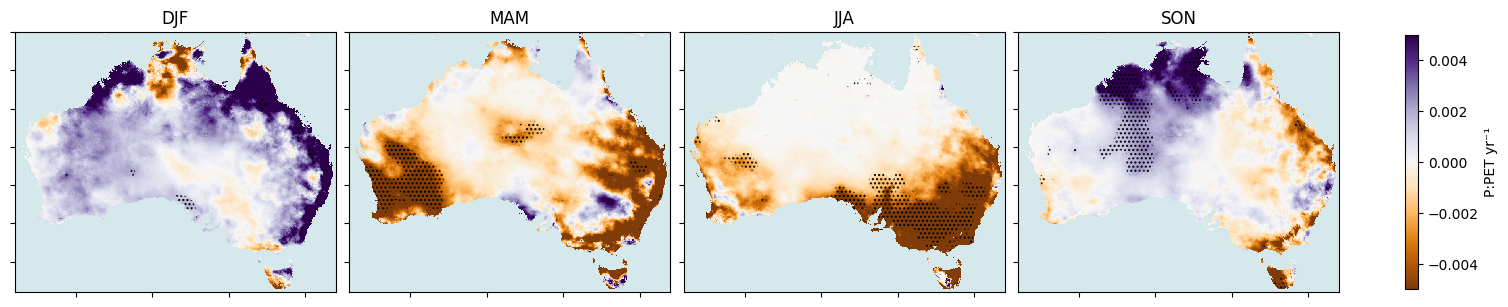

In [12]:
fig,ax = plt.subplots(1,4, figsize=(15,4),sharey=True, layout='constrained')
for s, a in zip(["DJF", "MAM", "JJA", "SON"], ax.reshape(-1)):
    im = mi_res[s].trend.where(mi_res[s].trend!=0).plot(ax=a, cmap='PuOr', vmin=-0.005, vmax=0.005, add_colorbar=False)
    ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    xr.plot.contourf(mi_res[s].trend.where(mi_res[s].signif), ax=a, alpha=0, hatches=['....'], add_colorbar=False)
    a.set_title(s)
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

cb = fig.colorbar(im, ax=ax, shrink=0.65, orientation='vertical', label='P:PET yr\u207B\u00B9')
fig.savefig("/g/data/os22/chad_tmp/Aus_phenology/results/figs/mi_seasonal_trends.png", bbox_inches='tight', dpi=300)

### Calculate early and later climatologies

In [ ]:
ds_cml = ds.rolling(time=3, min_periods=3).sum()

In [ ]:
early_clim = ds_cml.sel(time=slice('1960','1990')).groupby('time.month').mean()
late_clim = ds_cml.sel(time=slice('1991','2022')).groupby('time.month').mean()

early_clim_max = allNaN_arg(early_clim, 'month', 'max')
late_clim_max = allNaN_arg(late_clim, 'month', 'max')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(5,4))
# early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
# late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
# ax.legend()
# ax.set(xticks=range(1,13))
# ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);


### Difference in climatology

and clean up, e.g.:
- january(1) moves to december(12): 1-12 = -11, which should in fact be -1 (peak rainfall has moved backwards 1 month.)
- December(12) moves to Jan(1): 12-1 = 11, which should in fact be 1 (peak rainfall has moved forwards 1 month.)

In [ ]:
diff = (late_clim_max - early_clim_max)
diff_clean = xr.where(diff==11, 1, diff)
diff_clean = xr.where(diff==10, 2, diff_clean)
diff_clean = xr.where(diff==9, 3, diff_clean)
diff_clean = xr.where(diff==-11, -1, diff_clean)
diff_clean = xr.where(diff==-10, -2, diff_clean)
diff_clean = xr.where(diff==-9, -3, diff_clean)

In [ ]:
corr_data = [early_clim_max, late_clim_max, (diff_clean)] 
products=['1960-1990', '1991-2022','Difference (recent - past)'] 

fig,axes = plt.subplots(1,3, figsize=(14,5), sharey=True)

for ax, dss, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference (recent - past)':
        cmap='PuOr'
        vmin=-6
        vmax=6
    else:
        cmap='twilight'
        vmin=1
        vmax=12
    im = dss.plot(cmap=cmap, ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False)   
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    if n=='Difference (recent - past)':
        cbar = fig.colorbar(im, orientation='horizontal',
                ax=ax,
                cmap=cmap,
                ticks=[-6, -4, -2, 0, 2, 4, 6],
                shrink=0.80
               )
        cbar.ax.set_title('<--shifted early      shifted later-->', fontsize=10)
        cbar.ax.tick_params(labelsize=10)
    else:
        cbar = fig.colorbar(im, orientation='horizontal',
                        ax=ax,
                        norm = mpl.colors.Normalize(vmin=1, vmax=12),
                        ticks=[1,2,3,4,5,6,7,8,9,10,11,12],
                        cmap=cmap,
                        shrink=0.80
                       )
        cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10)
        cbar.ax.set_title('Month of max. three-month cml. rainfall', fontsize=10)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n}', fontsize=12)
    ax.set_ylabel('')
    ax.set_xlabel('')

plt.subplots_adjust(wspace=0.075)
fig.savefig(f'/g/data/os22/chad_tmp/AusENDVI/results/figs/peak_3M_rainfall_shifting_patterns.png',
            bbox_inches='tight', dpi=300);